<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.c.autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector

import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, CSVLogger


# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
!pip install git+git://github.com/stared/livelossplot.git
from livelossplot.keras import PlotLossesCallback


# The following is to be able to mount Google Drive
from google.colab import drive
import os



# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime 
%load_ext autotime

--2020-04-06 09:54:01--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py.12’

andrea_models.py.12 100%[===================>]   3.12K  --.-KB/s    in 0s      

2020-04-06 09:54:01 (68.6 MB/s) - ‘andrea_models.py.12’ saved [3190/3190]

--2020-04-06 09:54:02--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP req

### Mount google drive

In [13]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/06.clustering-and-anomaly/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
time: 21.2 s


### Preprocessing

The following code is the same as in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb).

In [14]:
np.random.seed(9)
random.seed(9)

! wget https://datahub.io/machine-learning/creditcard/r/creditcard.csv

df = pd.read_csv('creditcard.csv')
df.head()

df.info(verbose=True)
df['Class'].value_counts()
num_of_normal = sum( df['Class']=="'0'" )
num_of_anomalies = sum( df['Class']=="'1'" )
num_of_anomalies/num_of_normal

df = df.drop('Time', axis=1)
X = df.drop('Class', axis=1)
y = [1 if c=="'1'" else 0 for c in df['Class']] 

--2020-04-06 09:40:14--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.18.49.253, 104.18.48.253, 2606:4700:3031::6812:30fd, ...
Connecting to datahub.io (datahub.io)|104.18.49.253|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2020-04-06 09:40:16--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.18.48.253, 104.18.49.253, 2606:4700:3031::6812:30fd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.18.48.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv.1’

creditcard.csv.1    100%[===================>] 144.11M  79.6MB/s    in

With autoencoders, it is crucial **to scale** the dataset.

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

time: 185 ms


# Autoencoder build and training

Let's write the functions to build and train the model, similar to what we did in our [Neural Network's notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/04.neural_networks/neural_networks.ipynb).

In [34]:
n_features = X_scaled.shape[1]
act_fun = 'tanh'

def build_model():

  model = Sequential(
      Dense(10, input_dim = n_features, activation=act_fun), # Encoder
      Dense(5, activation=act_fun), ### Latent representation
      Dense(10, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  )


  model.compile(loss='mean_squared_error', optimizer='adam')


model = build_model()

TypeError: ignored

time: 44.7 ms


In [17]:
def train_model(nn_file, X_tr, y_tr, epochs, overwrite=False):
  """
  nn_file:  Before training, the model contained in this file will be loaded
            After training, the resulting model will be written in this file

  
  overwrite: If true, the model will be built and trained from scratch
  """

  ###################################
  #### CALLBACKS ####################
  ###################################
  plot_cb =  PlotLossesCallback() # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history


  if overwrite==True:
    os.remove(nn_file)
    os.remove(nn_file+'.csv')

  if not os.isfile(nn_file):
    model = build_model()
  else:
    model = load_model(nn_file)

  history = model.fit(X_tr, y_train, epochs=epochs,
                      callbacks=[plot_cb, checkpoint_cb, logger_cb],
                      validation_split=0.2)
  
  return model

time: 8.91 ms


Let's now build and train our first autoencoder

In [33]:
model = build_model()

TypeError: ignored

time: 59 ms


# Tune the Precision-Recall curve and the ROC curve

We will apply isolation forests on the credit card fraud dataset, already used in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb). A similar notebook can be found in [Kaggle](https://www.kaggle.com/amarnayak/testing-isolation-forest-for-fraud-detection). 

 As in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb), we separate training and test set.

In [0]:
X, y = shuffle(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
model = IsolationForest()

time: 259 ms


Our approach is unsupervised, so we **don't use y into fit(..)**

In [0]:
model.fit(X_train)
anomaly_scores = - model.decision_function(X_train)

time: 7.64 s


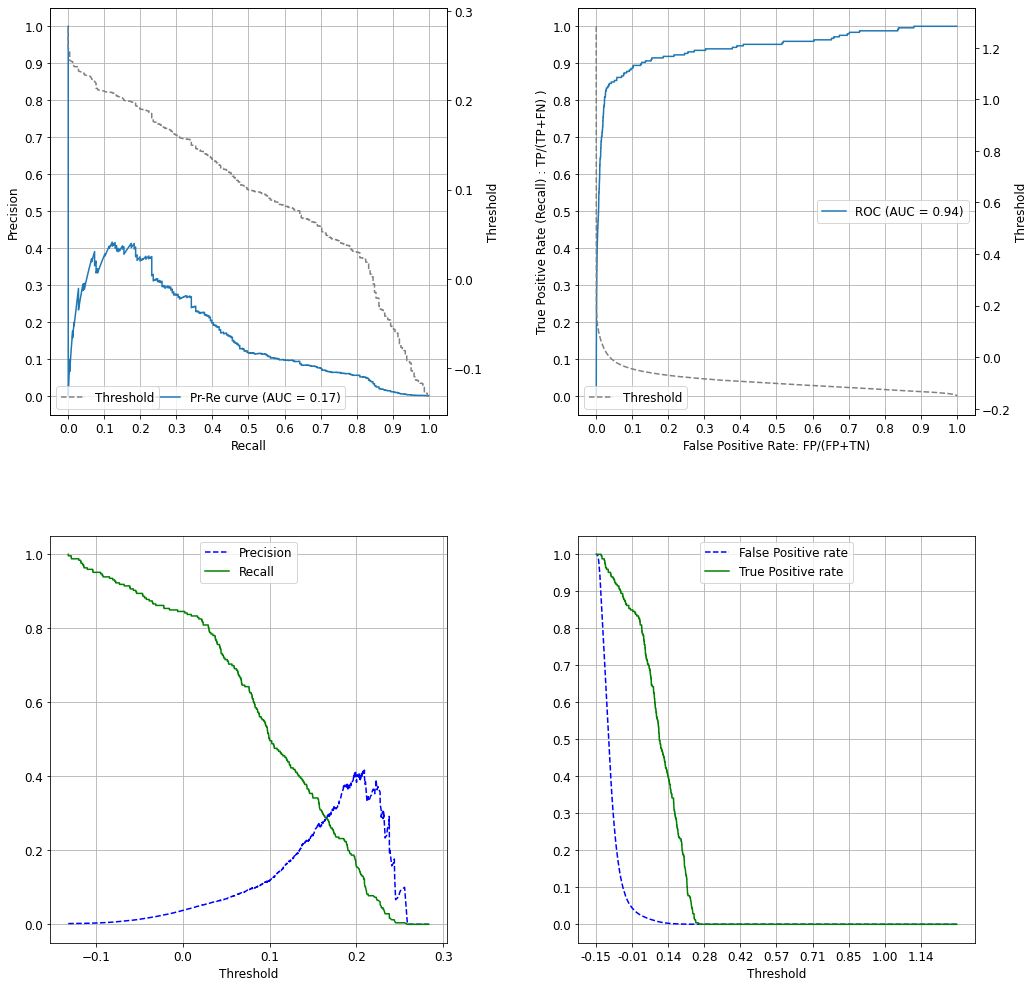

time: 1.47 s


In [0]:
evaluate_anomaly_detector(y_train, anomaly_scores)

Our isolation tree is still bad. The AUC of the precision-recall and ROC curves can be improved

### Number of trees

Increasing the number of trees always improves performance

In [0]:
model = IsolationForest(n_estimators=500)
model.fit(X_train)


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=500,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

time: 10.3 s


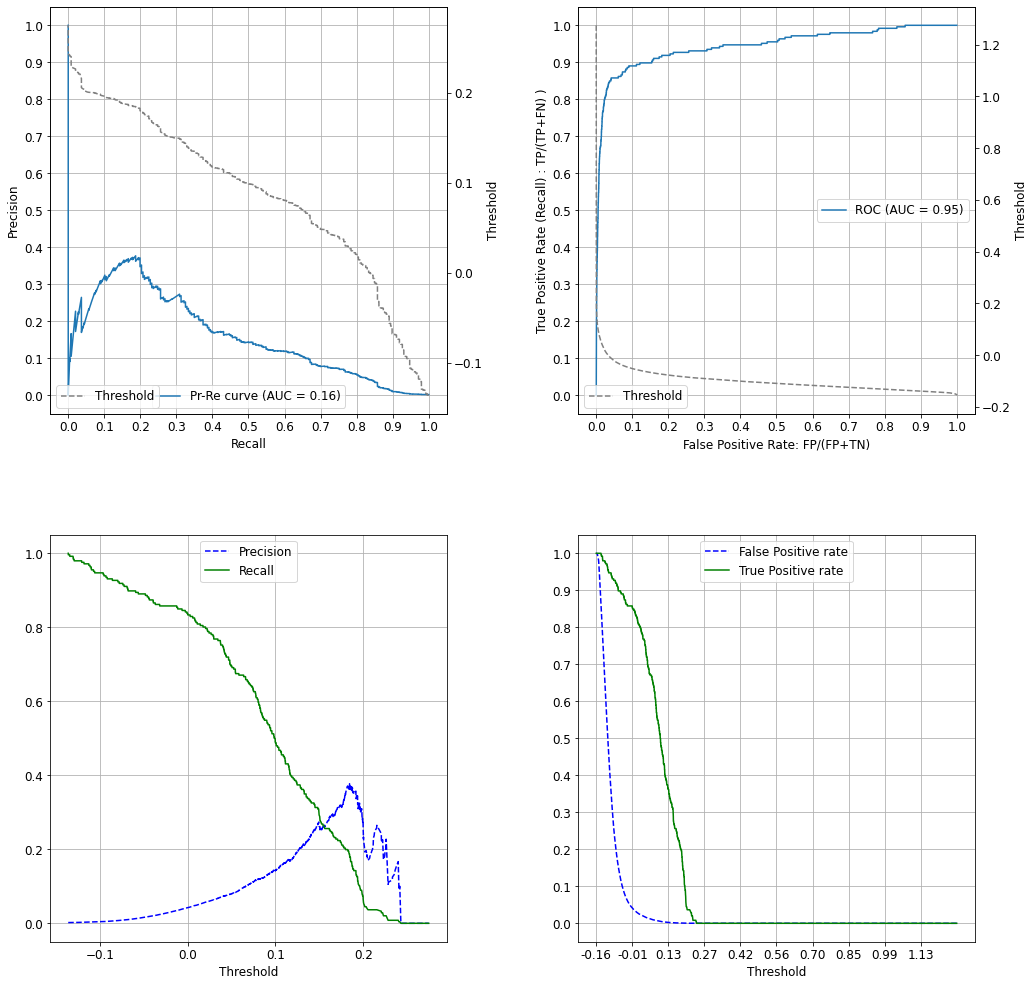

time: 29.5 s


In [0]:
anomaly_scores = -model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

### Others

GridSearch from `sklearn` is not simple (however not impossible) to apply. It is more simple to make a grid search manually

In [0]:
iforest = IsolationForest(n_estimators=500)

for max_features in [1, 15, 29]:
  for max_samples in range(256, X_train.shape[0], int(X_train.shape[0] / 3) ):
    model = IsolationForest(n_estimators=500, max_features=max_features,
                            max_samples = max_samples)
    model.fit(X_train)
    anomaly_scores = -model.decision_function(X_train)
    auc_score = average_precision_score(y_train, anomaly_scores)
    print("max_fetaures:", max_features, "; max_samples:", max_samples, 
          "auc_score:", auc_score)

max_fetaures: 1 ; max_samples: 256 auc_score: 0.1554807662884762
max_fetaures: 1 ; max_samples: 47723 auc_score: 0.20355469917939423
max_fetaures: 1 ; max_samples: 95190 auc_score: 0.1956571483808927
max_fetaures: 15 ; max_samples: 256 auc_score: 0.15042149906743724
max_fetaures: 15 ; max_samples: 47723 auc_score: 0.22126354642389168
max_fetaures: 15 ; max_samples: 95190 auc_score: 0.23036654280846913
max_fetaures: 29 ; max_samples: 256 auc_score: 0.13996559969003916
max_fetaures: 29 ; max_samples: 47723 auc_score: 0.22654100539764696
max_fetaures: 29 ; max_samples: 95190 auc_score: 0.23050696911613683
time: 7min 1s


Let's evaluate the best configuration we found

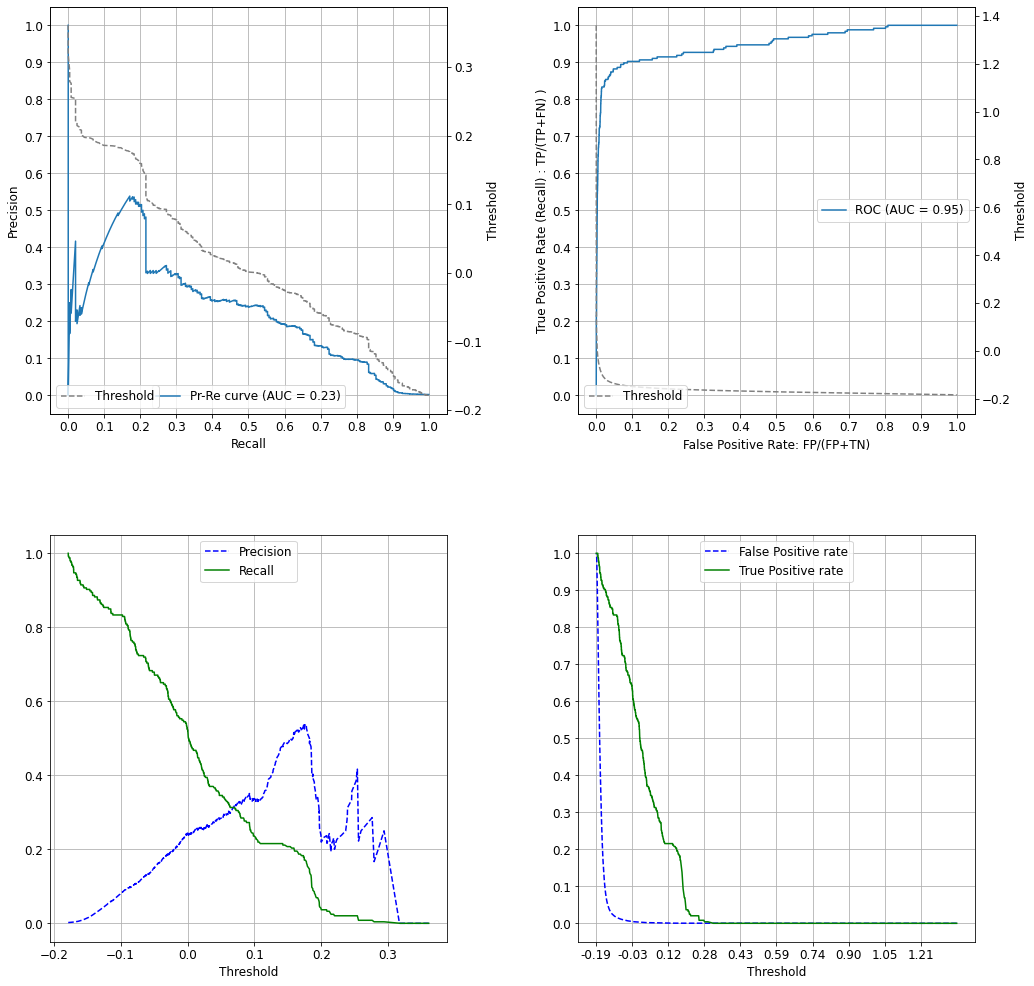

time: 57.5 s


In [0]:
n_estimators=500
max_features = 29
max_samples = 47723

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)
anomaly_scores = -model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

Note that `auc_score` is different, since isolation forests have a lot of randomness.

No real improvement. Increase further the number of trees.

In [0]:
n_estimators = 1500

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=29, max_samples=47723, n_estimators=1500,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

time: 56.5 s


In [0]:

anomaly_scores = -model.decision_function(X_train)

time: 1min 52s


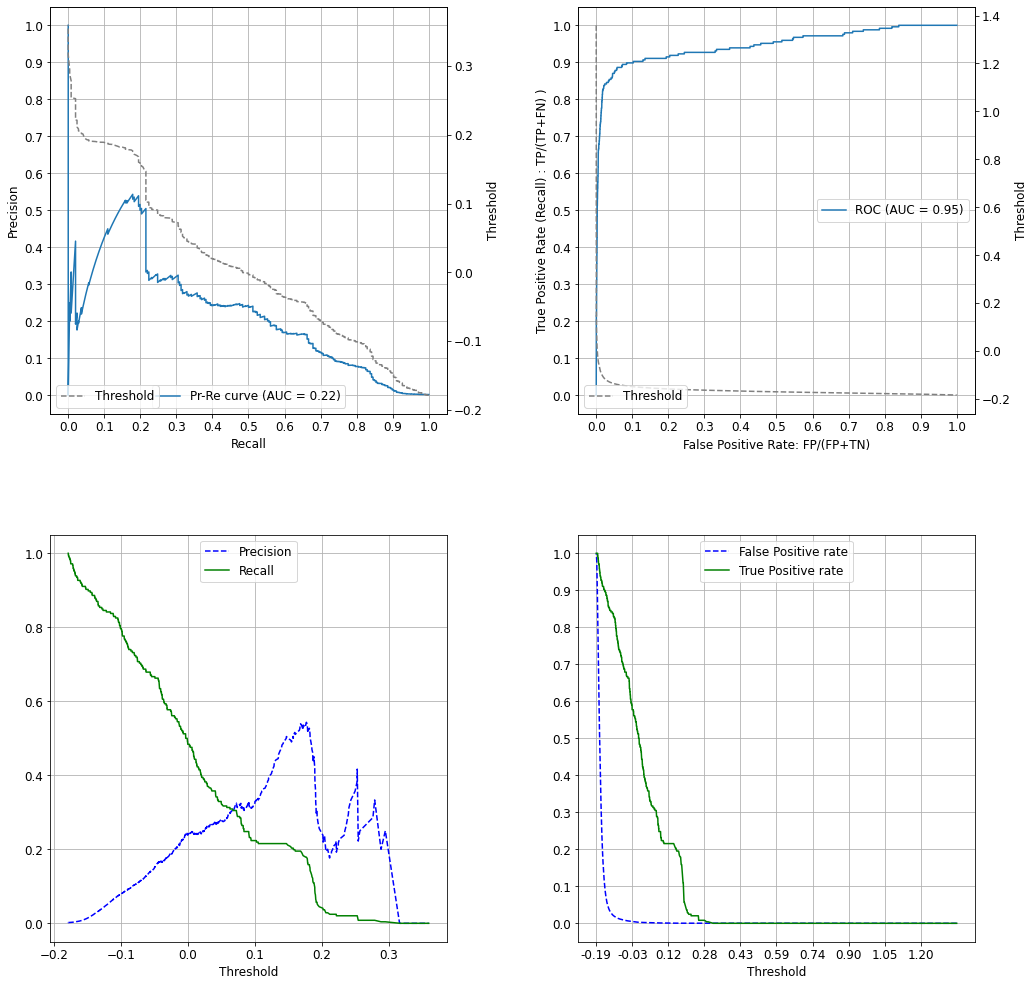

time: 1.59 s


In [0]:
evaluate_anomaly_detector(y_train, anomaly_scores)

# Fix the threshold

A good threshold could be:

Precision= 0.014147336222278869
Recall= 0.9024390243902439
False Positive Rate =  0.10882334320504794
True Positive Rate =  0.9024390243902439


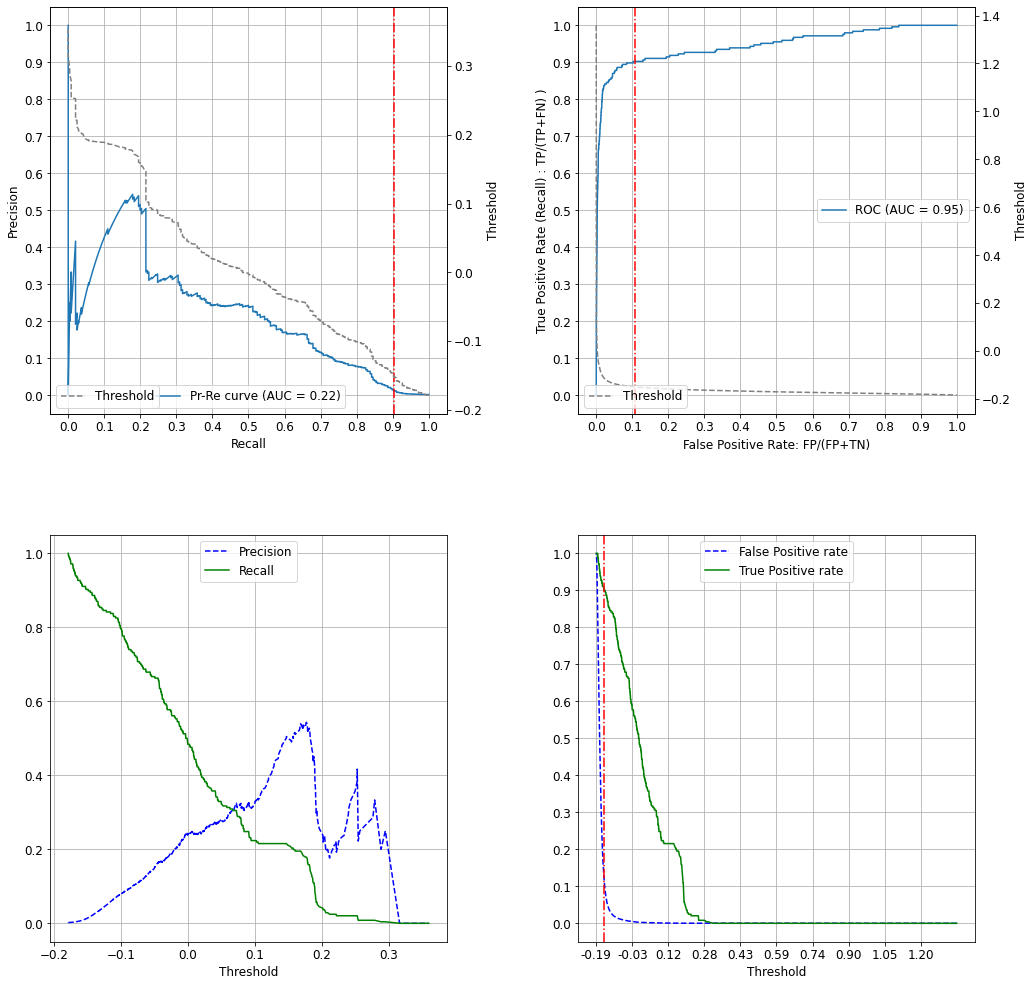

time: 2.31 s


In [0]:
threshold_selected = -0.15

evaluate_anomaly_detector(y_train, anomaly_scores, 
                          threshold_selected=threshold_selected)

But the false positive rate is too high. We need to renounce to some recall

Precision= 0.059554784619832324
Recall= 0.8373983739837398
False Positive Rate =  0.02288315031971693
True Positive Rate =  0.8373983739837398


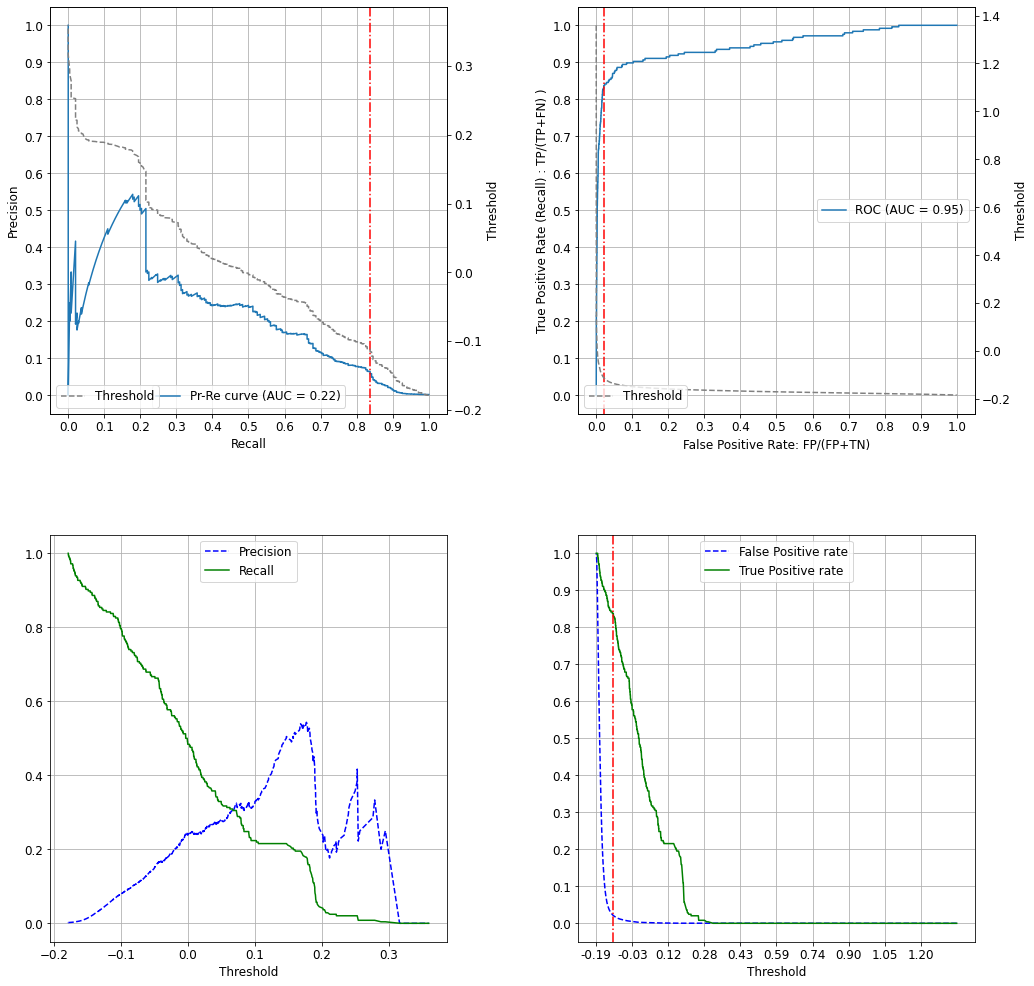

time: 2.35 s


In [0]:
threshold_selected = -0.115

evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

With this choice
* We find 84% of frauds
* We raise false alarms for 2% of normal activities

# Test


In [0]:
model.fit(X_test)
an_scores = -model.decision_function(X_test)

time: 2min 57s


In [0]:
y_pred = (an_scores >= threshold_selected)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("precision=", precision)
print('recall=', recall)
print('false positive rate=', fpr)


precision= 0.054257319366102605
recall= 0.8211382113821138
false positive rate= 0.02476821564737827
time: 614 ms


Normalized confusion matrix
[[0.97523178 0.02476822]
 [0.17886179 0.82113821]]


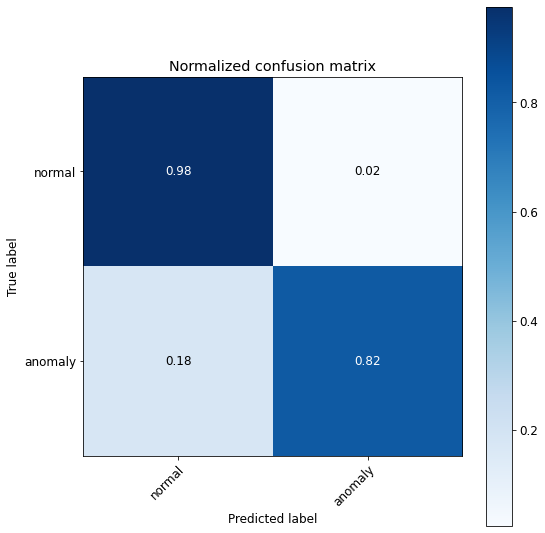

time: 668 ms


In [0]:
class_names= np.array( ['normal', 'anomaly'] )
plot_conf_mat(y_test, y_pred, class_names)

# Other examples of Autoencoders for anomaly detection

Check:
* [Handwritten digits](https://visualstudiomagazine.com/articles/2019/03/01/neural-anomaly-detection-using-keras.aspx)